# CNN Implementation #

In [1]:
import os

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from keras import backend as K
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Load Dateset #

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#data_path = '/content/drive/MyDrive/motionsense_dataset'
data_path = os.path.join(os.getcwd(), 'data')
save_path = os.path.join(os.getcwd(), 'temp_models')
print(os.listdir(data_path))

['dws_11', 'ups_12', '.DS_Store', 'wlk_7', 'std_14', 'wlk_15', 'wlk_8', 'dws_2', 'sit_13', 'jog_9', 'ups_3', 'ups_4', 'jog_16', 'dws_1', 'sit_5', 'std_6']


In [4]:
folders = glob(os.path.join(data_path,'*_*'))
folders = [s for s in folders if ("csv" not in s) or (".DS_Store" not in s) or (".ipynb" not in s)]
df_all_list = []
activity_codes = {'dws':0,'jog':1,'sit':2,'std':3,'ups':4,'wlk':5}
activity_decodes = {0:'dws',1:'jog',2:'sit',3:'std',4:'ups',5:'wlk'}
usr_cols = ['attitude.roll','attitude.pitch','attitude.yaw','userAcceleration.x','userAcceleration.y','userAcceleration.z']
activity_types = list(activity_codes.keys())
print(folders)

['/Users/apple/Desktop/CG4002_Capstone/ML/data/dws_11', '/Users/apple/Desktop/CG4002_Capstone/ML/data/ups_12', '/Users/apple/Desktop/CG4002_Capstone/ML/data/wlk_7', '/Users/apple/Desktop/CG4002_Capstone/ML/data/std_14', '/Users/apple/Desktop/CG4002_Capstone/ML/data/wlk_15', '/Users/apple/Desktop/CG4002_Capstone/ML/data/wlk_8', '/Users/apple/Desktop/CG4002_Capstone/ML/data/dws_2', '/Users/apple/Desktop/CG4002_Capstone/ML/data/sit_13', '/Users/apple/Desktop/CG4002_Capstone/ML/data/jog_9', '/Users/apple/Desktop/CG4002_Capstone/ML/data/ups_3', '/Users/apple/Desktop/CG4002_Capstone/ML/data/ups_4', '/Users/apple/Desktop/CG4002_Capstone/ML/data/jog_16', '/Users/apple/Desktop/CG4002_Capstone/ML/data/dws_1', '/Users/apple/Desktop/CG4002_Capstone/ML/data/sit_5', '/Users/apple/Desktop/CG4002_Capstone/ML/data/std_6']


In [71]:
test_df_dws = pd.read_csv(
    'data/dws_1/sub_1.csv',
    usecols = ['attitude.roll','attitude.pitch',
               'attitude.yaw','userAcceleration.x',
               'userAcceleration.y','userAcceleration.z']
)
test_df_ups = pd.read_csv(
    'data/ups_3/sub_1.csv',
    usecols = ['attitude.roll','attitude.pitch',
               'attitude.yaw','userAcceleration.x',
               'userAcceleration.y','userAcceleration.z']
)

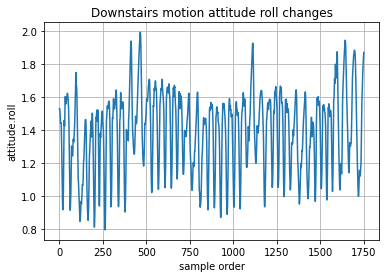

In [72]:
fig, ax = plt.subplots()
ax.plot(test_df_dws['attitude.roll'])
ax.set(xlabel='sample order', ylabel='attitude.roll',
       title='Downstairs motion attitude roll changes')
ax.grid()
plt.show()

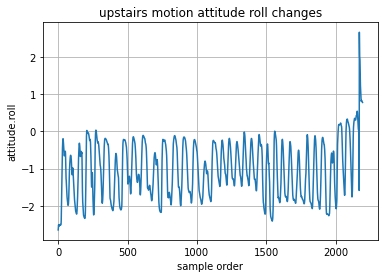

In [73]:
fig, ax = plt.subplots()
ax.plot(test_df_ups['attitude.roll'])
ax.set(xlabel='sample order', ylabel='attitude.roll',
       title='upstairs motion attitude roll changes')
ax.grid()
plt.show()

# CNN: Feature extraction, Train and Test ##

There are 24 data objects (people) performing motions. 6 different labels, each has different trials depending on time interval. 
We should get 24 * 15 = 360 such samples.


Long trials: those with number 1 to 9 with around 2 to 3 minutes duration.
Short trials: those with number 11 to 16 that are around 30 seconds to 1 minutes duration.

Sample rate is 50 Hz, this means a 2s window should have 100 samples.

In [74]:
#Feature extraction for NN model e.x. MLP
window = 600
feature_n = 6
attributes = ['attitude.roll', 'attitude.pitch', 'attitude.yaw','userAcceleration.x','userAcceleration.y','userAcceleration.z']
data_all_x_list = []
data_all_y_list = []
for j in folders:
    csv_list = glob(j + '/*')
    label = j.split('/')[-1].split('_')[0]
    for i in csv_list:
        df = pd.read_csv(
            i,
            usecols = ['attitude.roll','attitude.pitch',
                       'attitude.yaw','userAcceleration.x',
                       'userAcceleration.y','userAcceleration.z']
         )
        win_count = int(df.shape[0] / (window / 2)) - 1
        data_x = np.zeros((win_count, df.shape[1] * 5))
        data_y = np.zeros(win_count)

        length = len(df)
        for c in range(win_count):
            start_idx = int(c * (window / 2))
            end_idx = start_idx + window
            temp_list = []
            for k in range(feature_n):
                means = df[start_idx:end_idx][attributes[k]].mean()
                stds = df[start_idx:end_idx][attributes[k]].mean()
                mins = df[start_idx:end_idx][attributes[k]].min()
                maxs = df[start_idx:end_idx][attributes[k]].max()
                mads = df[start_idx:end_idx][attributes[k]].mad()
                temp_list.append(means)
                temp_list.append(stds)
                temp_list.append(mins)
                temp_list.append(maxs)
                temp_list.append(mads)
            data_x[c] = temp_list
            data_y[c] = activity_codes[label]

        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape)

(4174, 30)
(4174,)


## CNN 1. Feature Extraction + K-fold, Train & Test ##

In [75]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [76]:
train_x,test_x,train_y,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
assert(len(train_x) == len(train_y))
assert(len(test_x) == len(test_y))
print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)

(3339, 30) (835, 30)
(3339,) (835,)


In [77]:
kfold = KFold(n_splits=5, shuffle=True)

In [78]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [79]:
num_classes = 6
num_features = 30
batch_size = 32
acc_list = {}
f1_list = {}
train_acc_list = {}
fold_no = 1
epochs = 15
best_id = 1
best_acc = 0

for train, test in tqdm(kfold.split(train_x, train_y)):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = (30,1)),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(input_shape = (30,1)),
        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    _train_x = train_x[train]
    _train_y = train_y[train]
    _val_x = train_x[test]
    _val_y = train_y[test]
    length_train = _train_x.shape[0]
    length_val = _val_x.shape[0]
    _train_x = tf.convert_to_tensor(_train_x, dtype=tf.float32)
    _train_x = tf.reshape(_train_x, (length_train, num_features, 1))
    _val_x = tf.convert_to_tensor(_val_x, dtype=tf.float32)
    _val_x = tf.reshape(_val_x, (length_val, num_features, 1))
    _train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(_train_y,  num_classes=6), dtype=tf.float32)
    _val_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(_val_y,  num_classes=6), dtype=tf.float32)
#     _train_dataset = tf.data.Dataset.from_tensor_slices((_train_x, _train_y))
#     _val_dataset = tf.data.Dataset.from_tensor_slices((_val_x, _val_y))
    history = model.fit(
        _train_x,
        _train_y,
        epochs=epochs
    )
    train_acc = history.history['accuracy']
    print(f"===Highest training accuracy: {max(train_acc)}===")
#     loss, accuracy, f1_score, precision, recall = model.evaluate(_val_x, _val_y_1, verbose=0)
#     print(f"===loss:{loss}, accuracy:{accuracy}, precision:{precision}, recall:{recall}, f1_score:{f1_score}")
    y_pred = model.predict(_val_x, verbose=0)
#     print(y_pred)
    y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
    f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
    acc_metric = tf.keras.metrics.Accuracy()
    #acc_metric.update_state(train_y[test], y_pred_1)
    acc_metric.update_state(_val_y, y_pred_1)
    acc = acc_metric.result().numpy()
    # print(acc)
    #y_pred_1 = y_pred_1.astype(np.float32)
    #f1_metric.update_state(train_y_1, y_pred)
    f1_metric.update_state(_val_y_1, y_pred)
    f1_macro = f1_metric.result().numpy()
    if acc > best_acc:
        best_acc = acc
        best_id = fold_no
    # print(f1_macro)
    print(f"===Validation accuracy for fold {fold_no}: {acc}; f1_macro is {f1_macro}===")
    acc_list[fold_no] = acc
    train_acc_list[fold_no] = train_acc
    f1_list[fold_no] = f1_macro
    model.save(os.path.join(save_path, f"cnn_{fold_no}.h5"))
    fold_no += 1

0it [00:00, ?it/s]

Epoch 1/15
84/84 [==============================] - 1s 2ms/step - loss: 1.4453 - accuracy: 0.4227
Epoch 2/15
84/84 [==============================] - 0s 2ms/step - loss: 0.7554 - accuracy: 0.7196
Epoch 3/15
84/84 [==============================] - 0s 2ms/step - loss: 0.5679 - accuracy: 0.7888
Epoch 4/15
84/84 [==============================] - 0s 3ms/step - loss: 0.4797 - accuracy: 0.8121
Epoch 5/15
84/84 [==============================] - 0s 3ms/step - loss: 0.4218 - accuracy: 0.8375
Epoch 6/15
84/84 [==============================] - 0s 3ms/step - loss: 0.3928 - accuracy: 0.8469
Epoch 7/15
84/84 [==============================] - 0s 3ms/step - loss: 0.3702 - accuracy: 0.8566
Epoch 8/15
84/84 [==============================] - 0s 3ms/step - loss: 0.3452 - accuracy: 0.8663
Epoch 9/15
84/84 [==============================] - 0s 2ms/step - loss: 0.3145 - accuracy: 0.8723
Epoch 10/15
84/84 [==============================] - 0s 2ms/step - loss: 0.2980 - accuracy: 0.8847
Epoch 11/15
84/84 [

In [80]:
length_test= test_x.shape[0]
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
test_x = tf.reshape(test_x, (length_test, num_features, 1))
test_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=6), dtype=tf.float32)
best_model = tf.keras.models.load_model(os.path.join(save_path, f"cnn_{best_id}.h5"))
y_pred = best_model.predict(test_x, verbose=0)
#     print(y_pred)
y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
acc_metric = tf.keras.metrics.Accuracy()
#acc_metric.update_state(train_y[test], y_pred_1)
acc_metric.update_state(test_y, y_pred_1)
acc = acc_metric.result().numpy()
# print(acc)
#y_pred_1 = y_pred_1.astype(np.float32)
#f1_metric.update_state(train_y_1, y_pred)
f1_metric.update_state(test_y_1, y_pred)
f1_macro = f1_metric.result().numpy()
print(f"test accuracy is {acc}")
print(f"test f1 macro is {f1_macro}")

test accuracy is 0.940119743347168
test f1 macro is 0.899529755115509


In [81]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

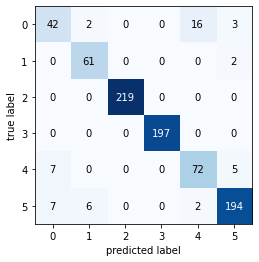

In [82]:
cm = confusion_matrix(y_target=test_y, 
                      y_predicted=y_pred_1, 
                      binary=False)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [83]:
_test_sample = test_df_dws[0:window]
temp_list = []
for k in range(feature_n):
    means = _test_sample[attributes[k]].mean()
    stds = _test_sample[attributes[k]].mean()
    mins = _test_sample[attributes[k]].min()
    maxs = _test_sample[attributes[k]].max()
    mads = _test_sample[attributes[k]].mad()
    temp_list.append(means)
    temp_list.append(stds)
    temp_list.append(mins)
    temp_list.append(maxs)
    temp_list.append(mads)
sample = np.asarray(temp_list).astype('float32').reshape((-1,1))
sample = tf.reshape(sample, (1, num_features, 1))
pred = best_model.predict(sample, verbose=0)
pred = np.argmax(pred, axis = 1)
print(f"This sample is a downstair motion, it is predicted to :{activity_decodes[pred[0]]}")

This sample is a downstair motion, it is predicted to :dws


## With out K-fold or Feature extraction, use validation set only ##
Update: We are testing this method with W9 data

### load real dataset ###
Dont be sad if it does not fit, at least it is real
This dataset is for w9, contains dab : 0, jamesbond: 1, mermaid:2

In [3]:
data_folder_path = os.path.join(os.getcwd(), 'w9_real_data')
folders = glob(os.path.join(data_folder_path,'*.csv'))
df_all_list = []
activity_codes = {'dab':0,'jamesbond':1,'mermaid':2}
activity_decodes = {0:'dab',1:'jamesbond',2:'mermaid'}
#usr_cols = ['attitude.roll','attitude.pitch','attitude.yaw','userAcceleration.x','userAcceleration.y','userAcceleration.z']
activity_types = list(activity_codes.keys())
print(folders)

['/Users/apple/Desktop/CG4002_Capstone/ML/w9_real_data/dab.csv', '/Users/apple/Desktop/CG4002_Capstone/ML/w9_real_data/jamesbond.csv', '/Users/apple/Desktop/CG4002_Capstone/ML/w9_real_data/mermaid.csv']


(403, 8)


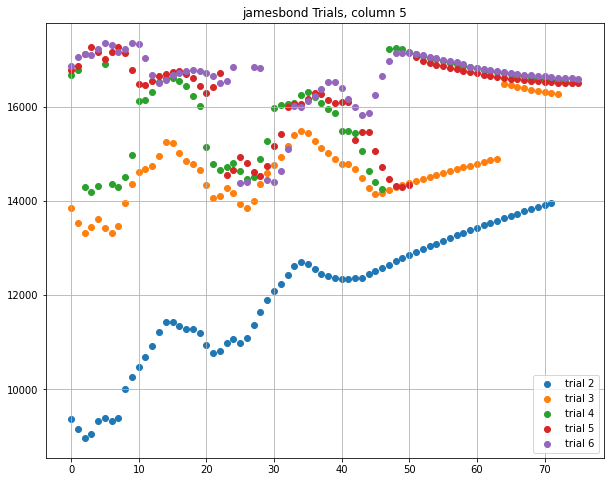

In [26]:
dab_data = pd.read_csv(os.path.join(data_folder_path, 'jamesbond.csv'), index_col = False)
print(dab_data.shape)

fig, ax = plt.subplots(figsize = [10,8])
for i in range(2,7):
    temp = dab_data[dab_data['0'] == i]
    x = [i for i in range(temp.shape[0])]
    ax.scatter(x, temp['5'], label = f"trial {str(i)}")

plt.title('jamesbond Trials, column 5')
plt.legend()
ax.grid()
plt.show()

In [52]:
# window size is 10 s, sample rate 50 Hz
# Sliding window, without Feature extraction nor low pass filter, for CNN only (dirrectly fits data in CNN)
window = 20
frequency = 20
# We need to skip the first trial
n_trials = 6
# from col 1 to 6: Accelerometer x, y, z, yall, pitch, roll
usr_cols = ['1','2','3','4','5','6']
drop_cols = ['0', 'Unnamed: 0']
data_all_x_list = []
data_all_y_list = []
for filename in folders:
    label_name = filename.split('/')[-1].split('.')[0]
    #print(label_name)
    motion_df = pd.read_csv(os.path.join(data_folder_path, filename), index_col = False)
    #print(f"motion_df's shape is : {motion_df.shape}")
    for i in range(1, 1 + n_trials):
        df = motion_df[motion_df['0'] == i]
#         drop_columns = list(set(df.columns) - set(usr_cols))
        df.drop(columns = drop_cols, inplace = True)
        length = df.shape[0]
        #print(df.shape)
        # We cut the ending part, if we don't have enough, we dont cut
        if length > window:
            cut_size = min(int(frequency / 2), length - window)
            length -= cut_size
            df = df[0:length]
            #print(f"shape after cut tail: {df.shape}")
        win_count = int(length / (window / 2)) - 1
        #print(win_count)
        data_x = np.zeros((win_count, window, df.shape[1]))
        data_y = np.zeros(win_count)
        for c in range(win_count):
            start_idx = int(c * (window / 2))
            end_idx = start_idx + window
            data_x[c,:,:] = df[start_idx:end_idx].values
            data_y[:] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape)      

(65, 20, 6)
(65,)


In [53]:
train_x_temp,test_x,train_y_temp,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
train_x,val_x,train_y,val_y = train_test_split(train_x_temp,train_y_temp,test_size=0.1)
assert(len(train_x) == len(train_y))
print(len(train_x), len(test_x),len(val_x))

46 13 6


In [54]:
# Save test file to be test in ultra96 with tflite
# print(test_x[100].shape)
# _label = test_y[100]
# print(_label)
# with open('test_single_y.txt', 'w') as f:
#     f.write('%d' % _label)
# pd.DataFrame(test_x[100]).to_csv("test_single_x.csv", index = False)
# pd.DataFrame(test_y[100]).to_csv("test_single_y.csv")

In [55]:
num_classes = 3
input_shape = (20, 6)
# val_y = np.asarray(val_y).astype('float32').reshape((-1,1))
# train_y = np.asarray(train_y).astype('float32').reshape((-1,1))
# test_y = np.asarray(test_y).astype('float32').reshape((-1,1))
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
val_x = tf.convert_to_tensor(val_x, dtype=tf.float32)
train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(train_y,  num_classes=num_classes), dtype=tf.float32)
test_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=num_classes), dtype=tf.float32)
val_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(val_y,  num_classes=num_classes), dtype=tf.float32)

In [56]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [57]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [58]:
for i,j in val_dataset.take(1):
    print(i.numpy().shape)
    print(j.numpy().shape)

(6, 20, 6)
(6, 3)


### Train & Test ###

In [59]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = input_shape),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Flatten(input_shape = input_shape),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 18, 32)            608       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 7, 32)             3104      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 4, 32)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2, 32)             3104      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)               

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/15


2021-10-10 19:57:41.475703: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2/2 [==============================] - 1s 169ms/step - loss: 2.1406 - accuracy: 0.2391 - val_loss: 1.2942 - val_accuracy: 0.5000
Epoch 2/15
2/2 [==============================] - 0s 14ms/step - loss: 1.9754 - accuracy: 0.2826 - val_loss: 1.2620 - val_accuracy: 0.5000
Epoch 3/15
2/2 [==============================] - 0s 12ms/step - loss: 1.9214 - accuracy: 0.1957 - val_loss: 1.2446 - val_accuracy: 0.1667
Epoch 4/15
2/2 [==============================] - 0s 13ms/step - loss: 1.7825 - accuracy: 0.1957 - val_loss: 1.1800 - val_accuracy: 0.1667
Epoch 5/15
2/2 [==============================] - 0s 15ms/step - loss: 1.5202 - accuracy: 0.1739 - val_loss: 1.1269 - val_accuracy: 0.1667
Epoch 6/15
2/2 [==============================] - 0s 11ms/step - loss: 1.6027 - accuracy: 0.2174 - val_loss: 1.1308 - val_accuracy: 0.3333
Epoch 7/15
2/2 [==============================] - 0s 12ms/step - loss: 1.4737 - accuracy: 0.2174 - val_loss: 1.1636 - val_accuracy: 0.1667
Epoch 8/15
2/2 [=====================

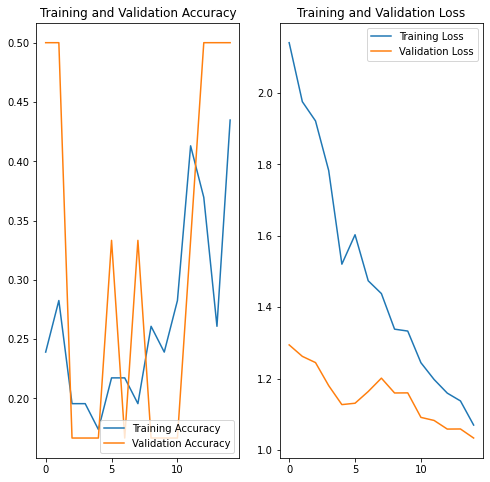

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [63]:
print(f"best training accruacy:{max(history.history['accuracy'])}")
print(f"best validation accruacy:{max(history.history['val_accuracy'])}")

best training accruacy:0.43478259444236755
best validation accruacy:0.5


In [16]:
# model.save('boing_cnn.h5')

In [17]:
model.save('boing_cnn_tflite.h5')
model_cnn_tflite= tf.keras.models.load_model('boing_cnn_tflite.h5')
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_tflite)
tflite_model = converter.convert()
with open('boing_cnn_tflite.tflite', 'wb') as f:
    f.write(tflite_model)

2021-10-10 10:49:13.127320: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/j5/8p7d3wls6rz_zgxtqcsldwkm0000gn/T/tmpm3gah4rm/assets


2021-10-10 10:49:13.981387: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-10-10 10:49:13.981902: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-10-10 10:49:13.995828: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.011ms.
  function_optimizer: function_optimizer did nothing. time = 0.006ms.

2021-10-10 10:49:14.171887: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2021-10-10 10:49:14.171908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2021-10-10 10:49:14.215683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `

In [75]:
# Different from noraml evluation, here we test the tflite file with a single input.
# if successful, the funciton can be moved to ultra96, we can call the ML model in ultra96.

# import tflite_runtime.interpreter as tflite
import time
def math_loser(input_data):
    interpreter = tf.lite.Interpreter(model_path='boing_cnn_tflite.tflite')
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # check the type of the input tensor
    floating_model = input_details[0]['dtype'] == np.float32

    # NxHxWxC, H:1, W:2
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]
    print(f"shape of the input required by model is {height}, {width}")
    input_data = np.reshape(input_data, (-1, height, width))
    print(f"shape of the input we passed in is {input_data.shape}")

    interpreter.set_tensor(input_details[0]['index'], input_data)

    start_time = time.time()
    interpreter.invoke()
    stop_time = time.time()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(f"initial prediction is {output_data}")
    
    results = np.squeeze(output_data)
    print(f"After squeeze it becomes {results}")
    
    pred = np.argmax(results)
    print(f"After argmax it becomes {pred}")

    print('time used: {:.3f}ms'.format((stop_time - start_time) * 1000))
    return pred

In [77]:
with open('test_single_y.txt', 'r') as f:
    _y = f.readline().strip()
print(_y)
_input_data = pd.read_csv("test_single_x.csv", index_col=False).to_numpy()
_input_data = _input_data.astype('float32')
print(f"shape of the input we passed in initially is {_input_data.shape}")
print(f"type of the input we passed in is {_input_data.dtype}")
pred = math_loser(_input_data)

5
shape of the input we passed in initially is (600, 6)
type of the input we passed in is float32
shape of the input required by model is 600, 6
shape of the input we passed in is (1, 600, 6)
initial prediction is [[-1.5823157 -2.308711  -3.385007  -4.0713854 -1.3870864  6.036119 ]]
After squeeze it becomes [-1.5823157 -2.308711  -3.385007  -4.0713854 -1.3870864  6.036119 ]
After argmax it becomes 5
time used: 0.902ms


In [64]:
model.evaluate(test_dataset,batch_size = BATCH_SIZE)

1/1 [==============================] - 0s 19ms/step - loss: 1.1042 - accuracy: 0.2308


[1.1041605472564697, 0.23076923191547394]